In [1]:
%load_ext autoreload
%autoreload 2

# Imagenet

In this notebook we explore the famous [ImageNet](https://www.image-net.org/) dataset, used over the last years to train and benchmark convnets. 

You can download the dataset from https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data

In [2]:
# !kaggle competitions download -c imagenet-object-localization-challenge

In [3]:
import os 
from glob import glob 
from pathlib import Path
import pandas as pd
import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

base_path = Path('/fastdata/ILSVRC')
path = Path(base_path / 'Data/CLS-LOC/')

We are provided images for trianing, validation and test. 

In [4]:
splits = os.listdir(path)
splits

['test', 'val', 'train']

Inside the training folder we have 1000 folders, one for each class. Inside each class folder we have the images for that class. Validation and test images are provided in a single folder.

In [5]:
classes = sorted(os.listdir(path/'train'))
assert len(classes) == 1000
val_images = os.listdir(path/'val')

len(classes), len(val_images), len(os.listdir(path/'test'))

(1000, 50000, 100000)

In [6]:
images, labels, cls = [], [], []
for i, c in enumerate(classes):
	this_images = glob(str(path/'train'/c/'*.JPEG'))
	images += this_images
	labels += [i] * len(this_images)
	cls += [c] * len(this_images)
train = pd.DataFrame({'image': images, 'label': labels, 'class': cls})
train

image  label      class
0        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
1        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
2        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
3        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
4        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
...                                                    ...    ...        ...
1281162  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281163  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281164  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281165  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281166  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141

[1281167 rows x 3 columns]

We have a total of 1281167 images for training, 50000 for validation and 100000 for test.

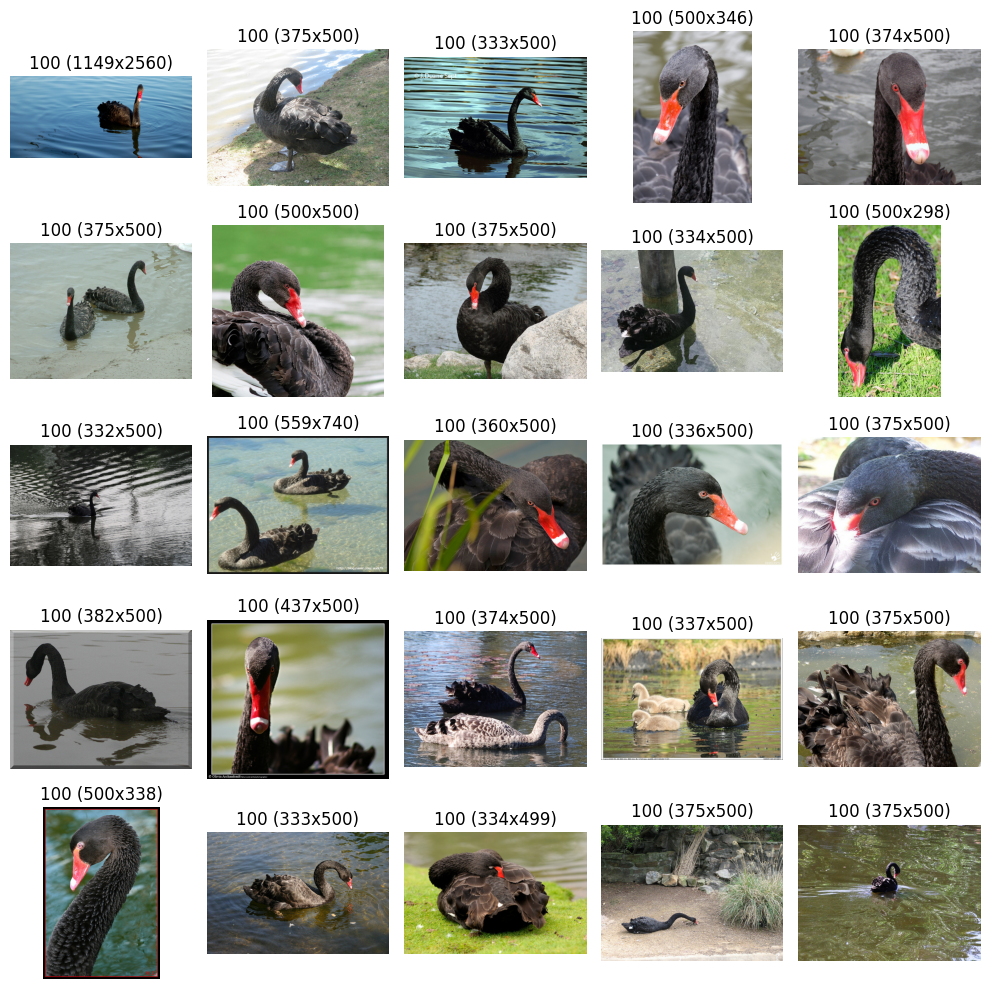

In [7]:
# plot samples

def plot_samples(df, label=100):
	samples = df[df.label == label].sample(25)
	fig = plt.figure(figsize=(10, 10))
	r, c = 5, 5
	for i in range(r * c):
		ax = fig.add_subplot(r, c, i + 1)
		img = plt.imread(samples.iloc[i]['image'])
		plt.imshow(img)
		plt.axis('off')
		h, w = img.shape[:2]
		plt.title(f'{samples.iloc[i]["label"]} ({h}x{w})')
	plt.tight_layout()
	plt.show()

plot_samples(train)

Images can have different resolutions. 

Validation labels can be extracted from the annotation files.

In [8]:
val_annotations = glob(str(base_path/'Annotations/CLS-LOC/val/*.xml'))
assert len(val_annotations) == len(val_images)

In [9]:
val_images, val_labels, val_cls = [], [], []
for ann in tqdm(val_annotations):
    # read xml
	tree = ET.parse(ann)
	root = tree.getroot()
	cls = root.findall('object')[0].find('name').text
	val_cls.append(cls)
	val_labels.append(classes.index(cls))
	val_images.append(path/'val'/f'{ann.split("/")[-1].split(".")[0]}.JPEG')

val = pd.DataFrame({'image': val_images, 'label': val_labels, 'class': val_cls})
val

100%|██████████| 50000/50000 [00:02<00:00, 23158.24it/s]


image  label      class
0      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    796  n04229816
1      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    936  n07714571
2      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    712  n03920288
3      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    202  n02098105
4      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    419  n02786058
...                                                  ...    ...        ...
49995  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    379  n02492660
49996  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    787  n04192698
49997  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    387  n02509815
49998  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...      7  n01514668
49999  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    669  n03788365

[50000 rows x 3 columns]

In [10]:
assert len(val.label.unique()) == len(classes)

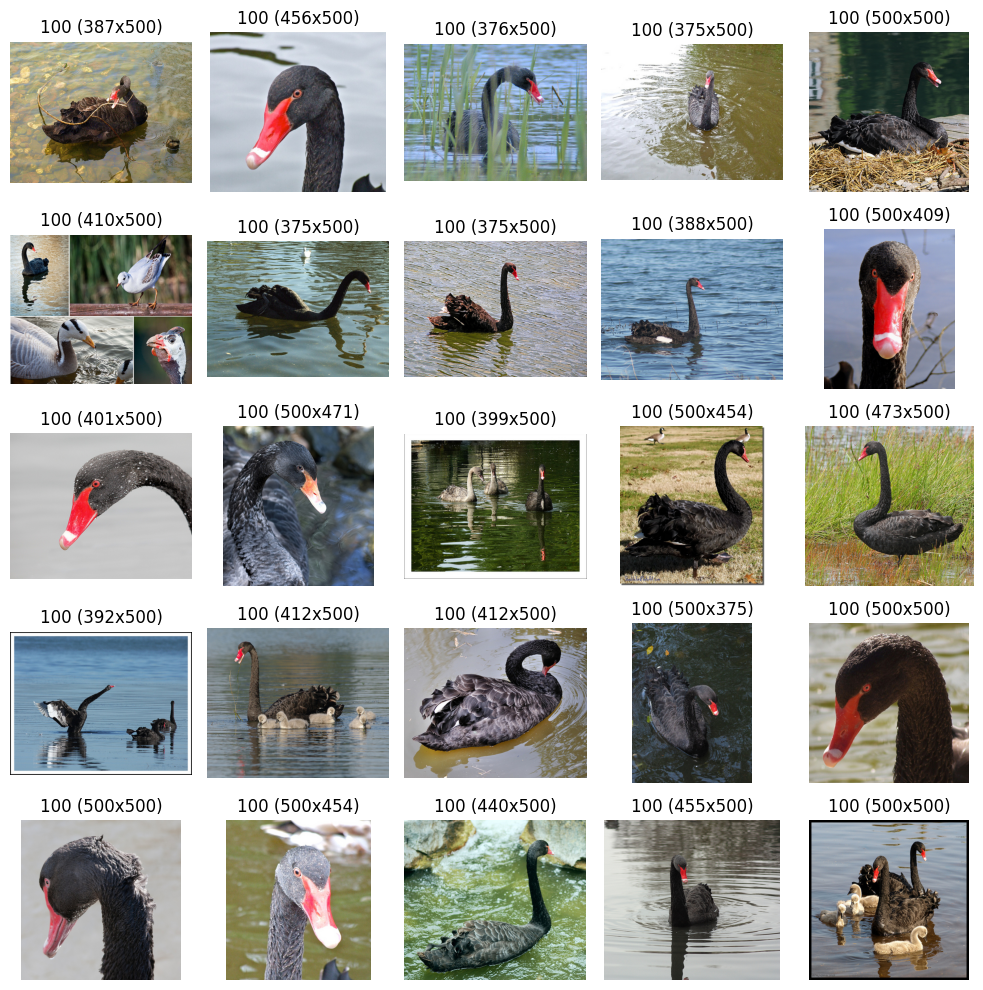

In [11]:
plot_samples(val)

Most models are trained on scaled versions of these images. To accelerate training we are going to resize them so the smallest side is 256 pixels and then take a center crop of size 256x256 and save them in a new directory.

In [12]:
from PIL import Image

def resize_and_crop(path, size=256):
	img = Image.open(path)
	w, h = img.size
	ar = w / h
	if ar > 1:
		img = img.resize((int(size * ar), size), Image.BILINEAR)
		w, h = img.size
		return img.crop((w//2 - size//2, 0, w//2 + size//2, size))
	img = img.resize((size, int(size / ar)), Image.BILINEAR)
	w, h = img.size
	return img.crop((0, h//2 - size//2, size, h//2 + size//2))	

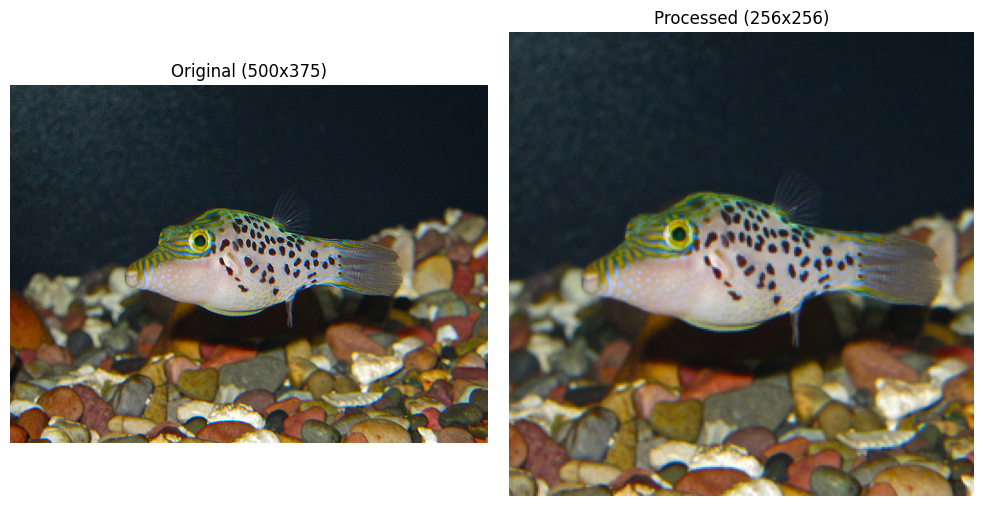

In [13]:
sample = train.sample(1).iloc[0].image
img = resize_and_crop(sample)
img0 = Image.open(sample)

# plot both images side by side 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img0)
plt.axis('off')
h,w = img0.size
plt.title(f'Original ({h}x{w})')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')
h, w = img.size
plt.title(f'Processed ({h}x{w})')
plt.tight_layout()
plt.show()

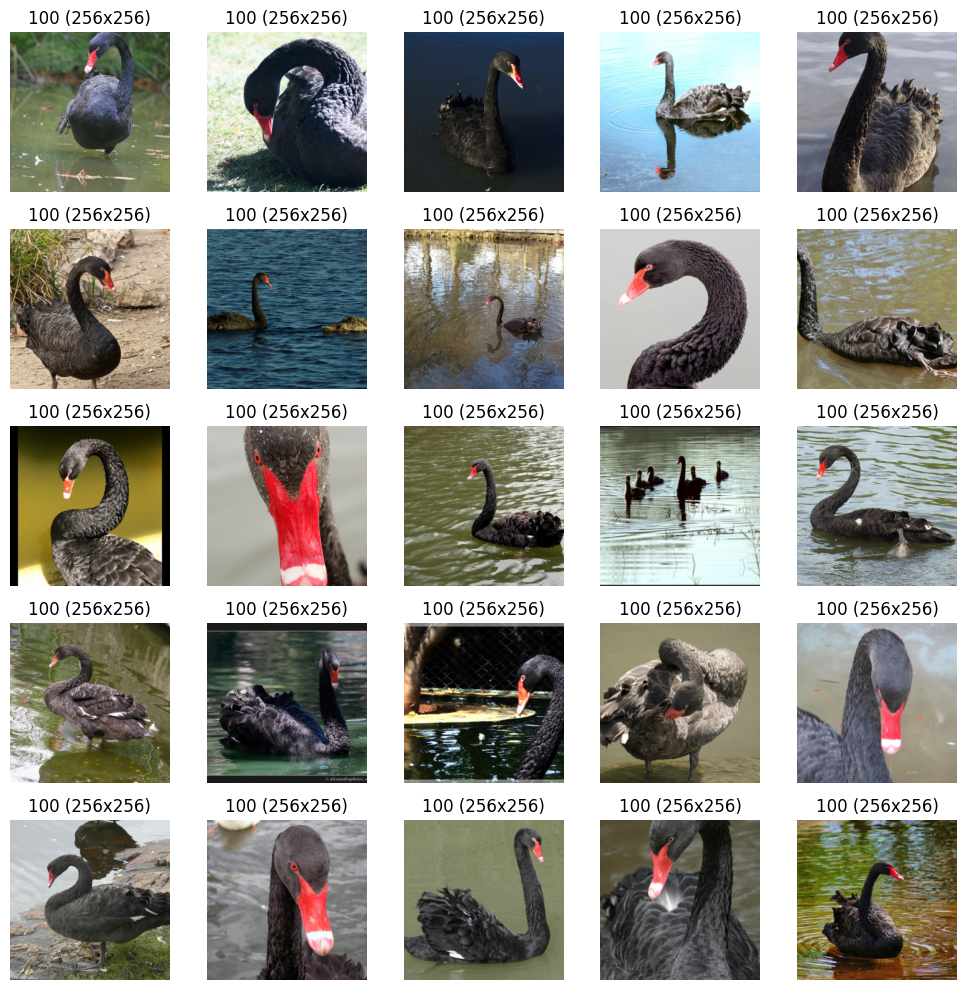

In [14]:
def plot_samples_resized(df, label=100):
	samples = df[df.label == label].sample(25)
	# samples = df.sample(25)
	fig = plt.figure(figsize=(10, 10))
	r, c = 5, 5
	for i in range(r * c):
		ax = fig.add_subplot(r, c, i + 1)
		img = resize_and_crop(samples.iloc[i]['image'])
		plt.imshow(img)
		plt.axis('off')
		h, w = img.size
		plt.title(f'{samples.iloc[i]["label"]} ({h}x{w})')
	plt.tight_layout()
	plt.show()

plot_samples_resized(train)

You can see an example script on how to process the dataset [here](convnets/datasets/imagenet.py). After running it you should have the images ready on the destination folder.

In [15]:
# from convnets.datasets.imagenet import process

# process()

In [16]:
path = Path('/fastdata/imagenet256')
splits = os.listdir(path)
splits

['test', 'val', 'train']

train/val splits contain 1000 folders with all the images for that class. The test folder contains all the test images.

In [17]:
classes = sorted(os.listdir(path/'train'))
assert len(classes) == 1000
assert len(classes) == len(os.listdir(path/'val'))

len(classes)

1000

In [18]:
len(os.listdir(path/'test'))

100000

In [19]:
images, labels, cls = [], [], []
for i, c in enumerate(classes):
	this_images = glob(str(path/'train'/c/'*.JPEG'))
	images += this_images
	labels += [i] * len(this_images)
	cls += [c] * len(this_images)
train = pd.DataFrame({'image': images, 'label': labels, 'class': cls})
train

image  label      class
0        /fastdata/imagenet256/train/n01440764/n0144076...      0  n01440764
1        /fastdata/imagenet256/train/n01440764/n0144076...      0  n01440764
2        /fastdata/imagenet256/train/n01440764/n0144076...      0  n01440764
3        /fastdata/imagenet256/train/n01440764/n0144076...      0  n01440764
4        /fastdata/imagenet256/train/n01440764/n0144076...      0  n01440764
...                                                    ...    ...        ...
1281162  /fastdata/imagenet256/train/n15075141/n1507514...    999  n15075141
1281163  /fastdata/imagenet256/train/n15075141/n1507514...    999  n15075141
1281164  /fastdata/imagenet256/train/n15075141/n1507514...    999  n15075141
1281165  /fastdata/imagenet256/train/n15075141/n1507514...    999  n15075141
1281166  /fastdata/imagenet256/train/n15075141/n1507514...    999  n15075141

[1281167 rows x 3 columns]

All images are resized and cropped.

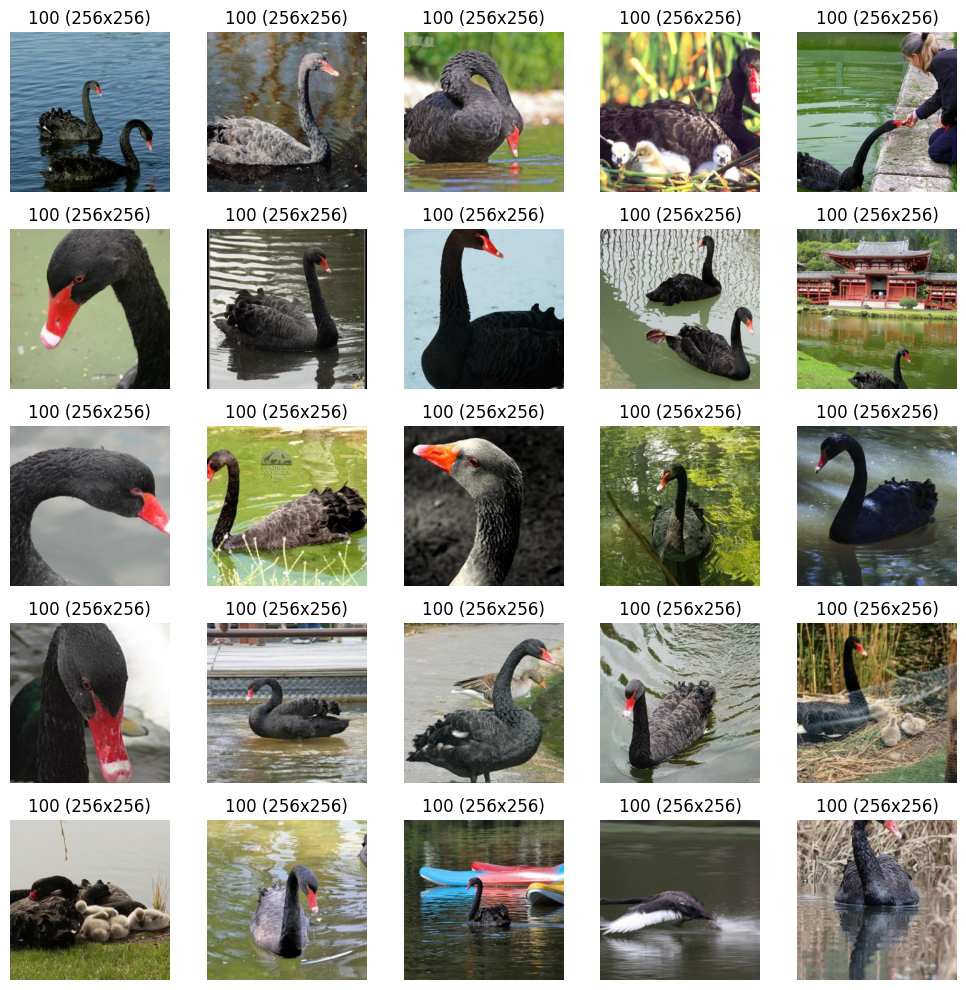

In [20]:
plot_samples(train)

Compute statistics for the dataset.

In [21]:
# from convnets.datasets.imagenet import compute_stats

# mean, std = compute_stats(train.image.values)
# mean, std

Train a model!

In [37]:
from convnets.train import fit 
import pandas as pd
import torch
from torch.utils.data import DataLoader
from convnets.train import seed_everything
import torchvision
import albumentations as A
from convnets.datasets import Imagenet

seed_everything()

trans = A.Compose([
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.RGBShift()
])

dataloaders  =  {
    'train': DataLoader(Imagenet(path, 'train', trans), batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(Imagenet(path, 'val', A.CenterCrop(224, 224)), batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

model = torchvision.models.resnet18(weights=False)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=5, limit_train_batches=100)

Training model on cuda


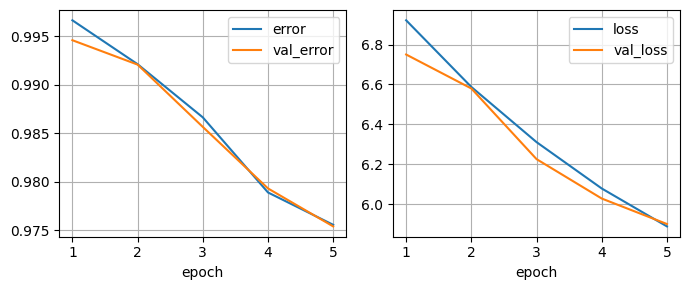

In [38]:
df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()